In [11]:
import csv
import pickle
import itertools
from collections import Counter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import dzcnapy_plotlib as dzcnapy
import os
import pandas as pd
import json
import spacy
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\burak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\burak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
def problem1():
    G = nx.Graph()
    
    df = pd.read_csv('facebook_combined.txt', sep=" ", header=None)
    df.columns = ["user1", "user2"]

    G.add_edges_from(list(zip(df.user1, df.user2)))
    G.add_nodes_from(list(set(df["user1"].tolist() + df["user2"].tolist())))
    
    numb_nodes = nx.number_of_nodes(G)

    numb_edges = nx.number_of_edges(G)
    
    print(nx.info(G))
    
    plt.figure(figsize=(10,10))
    nx.draw(G,node_size=5)
    plt.show()
    d=nx.degree_centrality(G) 
    top10=[]
    for w in sorted(d, key=d.get, reverse=True):
        top10.append(w)
    
    print(top10[:10])
    
    print("\n \n Degree centrality shows how much neighbors is that node has.")
    
problem1()

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


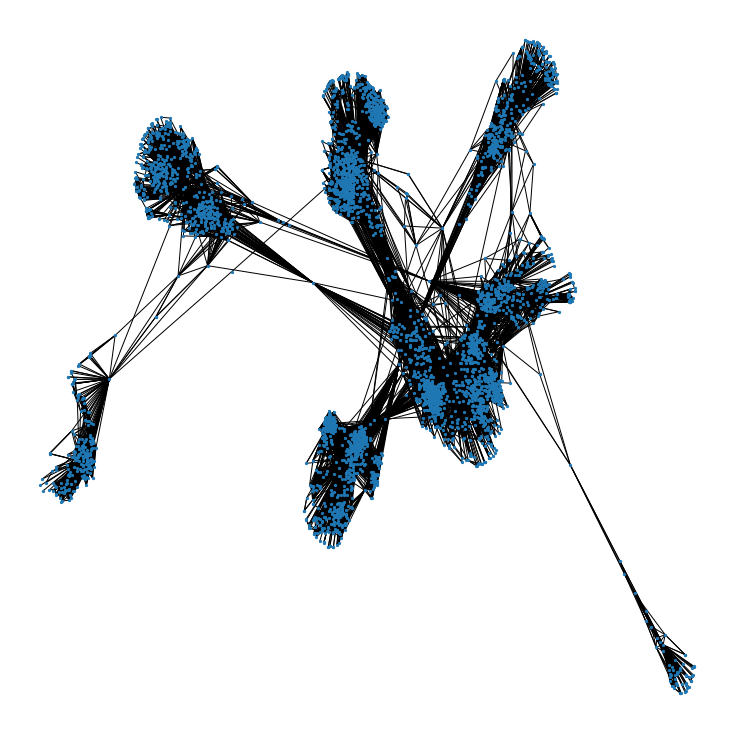

[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663]

 
 Degree centrality shows how much neighbors is that node has.


In [53]:
def problem2():
    G = nx.Graph()

    count=0
    tweets=[]
    tweets_clean=[]
    user = []
    retweeted_user = []
    for line in open('random_100k_set1.jsonl', 'r'):

        tweets.append(json.loads(line))
        
    for tweet in tweets:
        if "limit" not in tweet.keys():
            tweets_clean.append(tweet)
    tweets=tweets_clean
    
    
    for tweet in tweets:
        if tweet.get("retweeted_status") != None: 
            user.append(tweet.get("user").get("screen_name"))
            retweeted_user.append(tweet.get("retweeted_status").get("user").get("screen_name"))

    df = pd.DataFrame(list(zip(user, retweeted_user)), columns=['source', 'target'])
    df = df.groupby(['source','target']).size().to_frame(name = 'rt_number').reset_index().sort_values(by='rt_number', ascending=False)

    G = nx.from_pandas_edgelist(df, edge_attr=True, create_using=nx.DiGraph())

    df_in = pd.DataFrame(sorted(G.out_degree(weight='rt_number'), key=lambda x: x[1], reverse=True)[:10], columns=['screen_name', 'in_degree_with_weight'])
    df_out = pd.DataFrame(sorted(G.in_degree(weight='rt_number'), key=lambda x: x[1], reverse=True)[:10], columns=['screen_name', 'out_degree_with_weight'])
    df_degrees = pd.concat([df_out, df_in], axis=1, sort=False)
    
    return df_degrees

problem2()

,screen_name,out_degree_with_weight,screen_name,in_degree_with_weight
0,ekrem_imamoglu,1913,IslamGoksal,58
1,kacsaatolduson,1100,orhanpelin84,50
2,themarginale,733,REIS7206,46
3,cbabdullahgul,733,Hatice69180392,45
4,enveryan,613,EytKul,39
5,gazetesozcu,570,VeliKay54738267,38
6,ucurbenipegasus,549,ecrinakpinar,37
7,ismailsaymaz,494,MuratNR3,36
8,fatihportakal,490,maden_cigdem,36
9,06melihgokcek,480,musaciftci22,36


24039


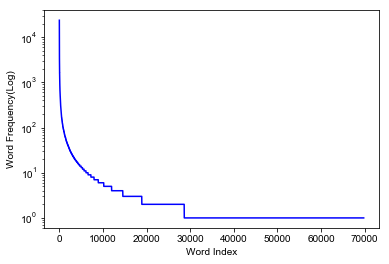

In [52]:
def problem3():
    count=0
    tweets=[]
    tweets_clean=[]
    user = []
    retweeted_id = []
    for line in open('random_100k_set1.jsonl', 'r'):
    
        tweets.append(json.loads(line))
        
    for tweet in tweets:
        if "limit" not in tweet.keys():
            tweets_clean.append(tweet)
    tweets=tweets_clean
    
    
    for tweet in tweets:
        if tweet.get("retweeted_status") != None: 
            retweeted_id.append(tweet.get("retweeted_status").get("id"))
            
    print(len(set(retweeted_id)))
    
    text=[]
    text2=[]
    for tweet in tweets:
        if tweet.get("retweeted_status") != None: 
            retweeted_id.append(tweet.get("retweeted_status").get("id"))
            text.append(tweet.get("retweeted_status").get("text"))
        if tweet.get("retweeted_status") == None:
            text2.append(tweet.get("text"))
            
            
    a=pd.DataFrame(set(list(zip(retweeted_id, text))))
    a=a[1].tolist()
    tweets=a+text2
    tweets=pd.Series(tweets)
    
    
    tweets=pd.Series(tweets)
    
    def delete_links(text):
        
        text = re.sub(r"http\S+", "", text)
        return [text]    
    def delete_handles(text):
        text_new=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
        return[text_new]
    def delete_RT(text):
        text_new=re.compile('\#').sub('', re.compile('RT').sub('', text, count=1).strip())
        return[text_new] 
    def delete_emoji(text):
        return [text.encode('ascii', 'ignore').decode('ascii')]
    def delete_StopWords(text):
        stops=set(stopwords.words("turkish"))
        for stop in stops:
            text_new = re.sub(stop, "", text) 
        return[text_new]
    
    text1=[]
    for tweet in tweets:
        text1.extend(delete_links(tweet))
    
    text2=[]
    for text in text1:
        text2.extend(delete_handles(text))
        
    text3=[]
    for text in text2:
        text3.extend(delete_RT(text))
        
    text4=[]
    for text in text3:
        text4.extend(delete_emoji(text))
        
    text5=[]
    for text in text4:
        text5.extend(delete_StopWords(text))
    
    
    nlp = spacy.load("xx_ent_wiki_sm") #https://spacy.io/usage/models
    
    words=[]
    for text in text5:   
        lem = nlp(text)
        # finding lemma for each word
        
        for word in lem:
            words.append(word.lemma_)
    
    c=Counter(words)
    
    frequency = pd.DataFrame.from_dict(c, orient='index').reset_index()
    
    frequency.columns=["index","values"]
    
    frequency.drop("index", inplace=True,axis=1)
    
    frequency.sort_values("values",inplace=True,ascending=False)
    
    frequency.reset_index(drop=True,inplace=True)
    
    
    plt.plot(frequency.index,frequency.values,'b-')
    plt.yscale('log')
    plt.ylabel("Word Frequency(Log)")
    plt.xlabel("Word Index")
    plt.show()
    
problem3()

https://spacy.io/usage/models